In [1]:
# Basic data load in and analysis for RAMSES data with yt
# Matt Sampson 2023

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import yt
import cmasher as cmr
import visu_ramses
import matplotlib as mpl
from scipy.interpolate import griddata

In [60]:
# plot params
plt.rcParams["xtick.top"] = True 
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = 'in' 
plt.rcParams["ytick.direction"] = 'in' 
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [61]:
# define path to data
PATH_prefix = "/scratch/gpfs/ms0821/monte_carlo_CR_2023/public_ramses/ramses/tests/"
PATH_suffix = "tracer/sedov/"
PATH = PATH_prefix + PATH_suffix

In [62]:
# Load RAMSES output
data = visu_ramses.load_snapshot(2)
x = data["data"]["x"]
y = data["data"]["y"]
dx = data["data"]["dx"]
rho = data["data"]["density"]

xp = data["particle"]["position_x"]
yp = data["particle"]["position_y"]
mp = data["particle"]["mass"]

Processing 1 files in output_00002
Total number of cells loaded: 16360
Total particles loaded: 249986


In [63]:
# Check that the tracer total mass agrees with the gas mass within
# 1/sqrt(Ntracer) (~1 sigma for a Poisson distribution)
Mgas = (data["data"]["density"] * data["data"]["dx"]**2).sum()
Mtracer = data["particle"]["mass"].sum()
Ntracer = data["particle"]["mass"].size
rtol = 1/np.sqrt(Ntracer)
np.testing.assert_allclose(Mgas, Mtracer, rtol=rtol)

In [64]:
# Normalize the tracer mass so that their sum equals the box mass
mp = mp * (rho * dx**2).sum() / mp.sum()

xmin = np.amin(x - 0.5 * dx)
xmax = np.amax(x + 0.5 * dx)
ymin = np.amin(y - 0.5 * dx)
ymax = np.amax(y + 0.5 * dx)

nx = 32
dpx = (xmax - xmin) / float(nx)
dpy = (ymax - ymin) / float(nx)
xpx = np.linspace(xmin + 0.5 * dpx, xmax - 0.5 * dpx, nx)
ypx = np.linspace(ymin + 0.5 * dpy, ymax - 0.5 * dpy, nx)
grid_x, grid_y = np.meshgrid(xpx, ypx)
points = np.transpose([x, y])
z1 = griddata(points, rho, (grid_x, grid_y), method="nearest")

xbins = np.linspace(xmin, xmax, nx + 1)
ybins = np.linspace(ymin, ymax, nx + 1)
xpoints = np.transpose([xp, yp])
z2, _1, _2 = np.histogram2d(xp, yp, bins=(xbins, ybins), weights=mp)
z2 *= z1.sum() / z2.sum()
Npart, _1, _2 = np.histogram2d(xp, yp, bins=(xbins, ybins))

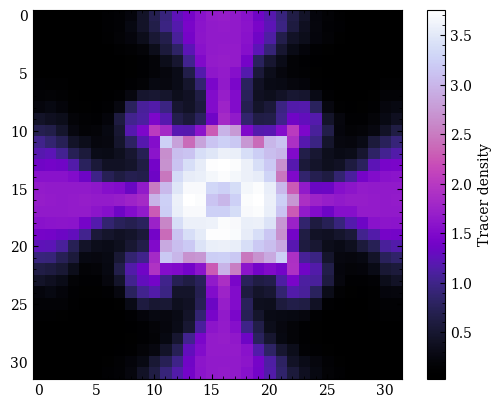

In [67]:
plt.imshow(z1, cmap='cmr.gothic')
plt.colorbar(label="Tracer density")

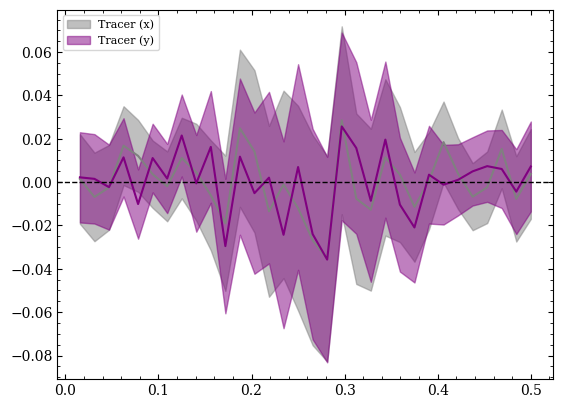

In [66]:
ymean_ref = z1.mean(axis=0)
ymean = z2.mean(axis=0)
yerr = (z2/np.sqrt(Npart)).mean(axis=0)
plt.plot(xbins[1:], ymean-ymean_ref, c="gray")
plt.fill_between(xbins[1:], ymean-ymean_ref-yerr/2, ymean-ymean_ref+yerr/2, label="Tracer (x)", color="gray", alpha=0.5)

ymean = z2.mean(axis=1)
yerr = (z2/np.sqrt(Npart)).mean(axis=1)
plt.plot(xbins[1:], ymean-ymean_ref, c="purple")
plt.fill_between(xbins[1:], ymean-ymean_ref-yerr/2, ymean-ymean_ref+yerr/2, label="Tracer (y)", color="purple", alpha=0.5)
plt.axhline(0, ls='--', lw=1, c='black')
plt.legend(loc="upper left", fontsize=8)